In [28]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import required Libraries

In [72]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys

##### Ignoring Warnings

In [30]:
import warnings
warnings.filterwarnings('ignore')


#### Import modules

In [31]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from preprocessing import PreProcess
from overview import Overview
from plot import Plot
from logger import Logger

In [32]:
# Initialize logger
logger = Logger("userEngagement.log").get_app_logger()
logger.info("Initialized userEngagement.py logger")

#### Import the Data

In [33]:
# df = pd.read_excel('../data/Week1_challenge_data_source.xlsx')
df_org = pd.read_csv('../data/cleaned_data_outliers.csv')

In [34]:
df = df_org.copy()

In [35]:
pl = Plot()
overview = Overview(df)

Data overview

In [36]:
df.head()

,bearer_id,start,start_ms,end,end_ms,dur._(ms),imsi,msisdn/number,imei,last_location_name,...,youtube_dl_(bytes),youtube_ul_(bytes),netflix_dl_(bytes),netflix_ul_(bytes),gaming_dl_(bytes),gaming_ul_(bytes),other_dl_(bytes),other_ul_(bytes),total_ul_(bytes),total_dl_(bytes)
0,1.311448e+19,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,0.996516,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,0.970502,0.822514,0.921154,0.938287,0.912787,0.988555,0.872215,0.945762,0.771197,0.778526
1,1.311448e+19,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,0.944446,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,0.989326,0.988470,0.982026,0.981643,0.974370,0.788814,0.962224,0.991811,0.886427,0.933206
2,1.311448e+19,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,0.944006,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,0.987317,0.967048,0.978865,0.904660,0.897724,0.702334,0.942217,0.882317,0.687728,0.758117
3,1.311448e+19,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,0.938611,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,0.993545,0.969493,0.961585,0.775449,0.995798,0.966299,0.990469,0.977834,0.820953,0.986552
4,1.311448e+19,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,0.903820,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,0.967557,0.987831,0.976847,0.702620,0.963140,0.876788,0.965772,0.985008,0.785599,0.904707


#### User Engagement Analysis

##### Total data volume (in Bytes) during this session for each application


In [37]:
df["social_media"] = df["social_media_dl_(bytes)"] + df['social_media_ul_(bytes)']
df["google"] = df["google_dl_(bytes)"] + df["google_ul_(bytes)"]
df['email'] = df["email_dl_(bytes)"] + df["email_ul_(bytes)"]
df['youtube'] = df["youtube_dl_(bytes)"] + df["youtube_ul_(bytes)"]
df['netflix'] = df["netflix_dl_(bytes)"] + df["netflix_ul_(bytes)"]
df["gaming"] = df["gaming_dl_(bytes)"] + df["gaming_ul_(bytes)"]
df['other'] = df["other_dl_(bytes)"]+df["other_ul_(bytes)"]
df['total_data'] = df['total_dl_(bytes)'] + df['total_ul_(bytes)']

In [38]:
df.columns

Index(['bearer_id', 'start', 'start_ms', 'end', 'end_ms', 'dur._(ms)', 'imsi',
       'msisdn/number', 'imei', 'last_location_name', 'avg_rtt_dl_(ms)',
       'avg_rtt_ul_(ms)', 'avg_bearer_tp_dl_(kbps)', 'avg_bearer_tp_ul_(kbps)',
       'tcp_dl_retrans._vol_(bytes)', 'tcp_ul_retrans._vol_(bytes)',
       'dl_tp_<_50_kbps_(%)', '50_kbps_<_dl_tp_<_250_kbps_(%)',
       '250_kbps_<_dl_tp_<_1_mbps_(%)', 'dl_tp_>_1_mbps_(%)',
       'ul_tp_<_10_kbps_(%)', '10_kbps_<_ul_tp_<_50_kbps_(%)',
       '50_kbps_<_ul_tp_<_300_kbps_(%)', 'ul_tp_>_300_kbps_(%)',
       'http_dl_(bytes)', 'http_ul_(bytes)', 'activity_duration_dl_(ms)',
       'activity_duration_ul_(ms)', 'dur._(ms).1', 'handset_manufacturer',
       'handset_type', 'nb_of_sec_with_125000b_<_vol_dl',
       'nb_of_sec_with_1250b_<_vol_ul_<_6250b',
       'nb_of_sec_with_31250b_<_vol_dl_<_125000b',
       'nb_of_sec_with_37500b_<_vol_ul',
       'nb_of_sec_with_6250b_<_vol_dl_<_31250b',
       'nb_of_sec_with_6250b_<_vol_ul_<_37500b',


Aggregate the number of session durations, total session duration, & total data for each user

In [39]:
df = df.rename( columns={'bearer_id': 'sessions'})

In [40]:
user_engagement = df.groupby('msisdn/number').agg({'sessions': 'count', 'dur._(ms)': 'sum', 'total_data': 'sum'})

In [41]:
user_engagement.head()

,sessions,dur._(ms),total_data
msisdn/number,,,
3.360100e+10,1,0.502300,1.751134
3.360100e+10,1,0.581407,1.350465
3.360100e+10,1,0.528418,1.691663
3.360101e+10,1,0.349441,1.425098
3.360101e+10,2,0.343253,3.558224


#### 2.1 Users data analysis

Get the top 10 users with the highest total data volume, sessions, & session duration

Aggregate the above metrics per customer id (MSISDN) and report the top 10 customers per engagement metric 


In [42]:
user_engagement.shape

(106856, 3)

In [43]:
# user_engagement = user_engagement[user_engagement.index.str.contains("3.366371e+10") == False]
user_engagement.drop(33663706799.0, axis=0, inplace=True)

In [44]:
sessions = user_engagement.nlargest(10, "sessions")['sessions']
duration = user_engagement.nlargest(10, "dur._(ms)")['dur._(ms)']
total_data = user_engagement.nlargest(10, "total_data")['total_data']


In [45]:
sesssions_df = pd.DataFrame()
sesssions_df['User_ID'] = sessions.index
sesssions_df['Sessions'] = sessions.values
durations_df = pd.DataFrame()
durations_df['User_ID'] = duration.index
durations_df['duration'] = duration.values
total_data_df = pd.DataFrame()
total_data_df['User_ID'] = total_data.index
total_data_df['total_data'] = total_data.values

In [46]:
sesssions_df.head()

,User_ID,Sessions
0,3.362632e+10,18
1,3.361489e+10,17
2,3.362578e+10,17
3,3.365973e+10,16
4,3.367588e+10,15


In [47]:
durations_df.head()


,User_ID,duration
0,3.362578e+10,14.843524
1,3.362632e+10,12.989967
2,3.361489e+10,12.871815
3,3.376054e+10,11.266070
4,3.366716e+10,10.296854


In [48]:
total_data_df.head()

,User_ID,total_data
0,3.362632e+10,28.335924
1,3.362578e+10,27.839376
2,3.361489e+10,27.478626
3,3.376054e+10,25.162286
4,3.365973e+10,25.139605


[]

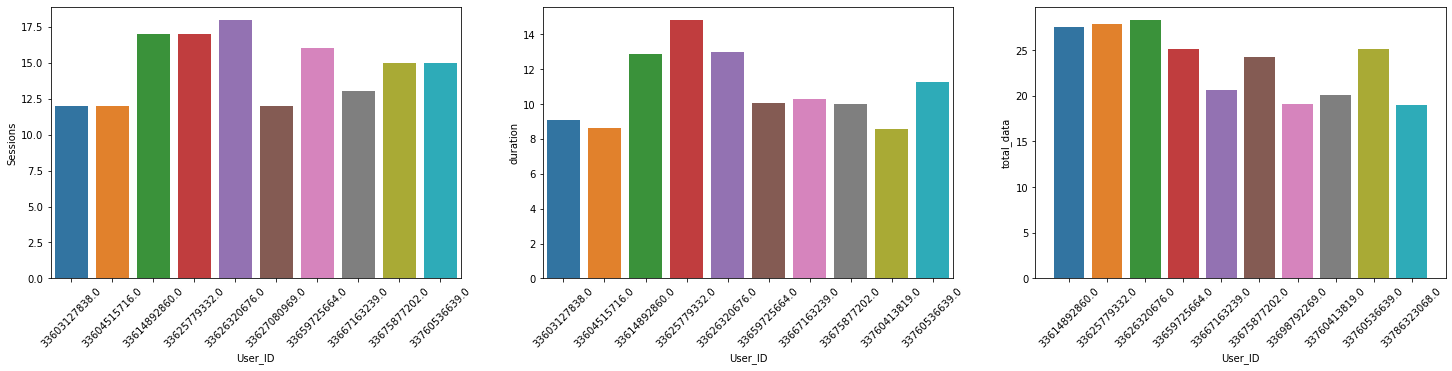

In [49]:
f, axes = plt.subplots(1, 3, figsize=(25, 5))
ax1 = sns.barplot(data=sesssions_df, x='User_ID', orient='v', y='Sessions', ax=axes[0])
ax2 = sns.barplot(data=durations_df, x='User_ID',orient='v', y='duration', ax=axes[1])
ax3 = sns.barplot(data=total_data_df, x='User_ID',orient='v', y='total_data', ax=axes[2])
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


Normalize each engagement metric and run a k-means (k=3) to classify customers in three groups of engagement. 


In [50]:
from sklearn.preprocessing import Normalizer

def normalizer(df, columns):
    norm = Normalizer()
    # normalize the exponential data with boxcox
    normalized_data = norm.fit_transform(df)

    # plot both together to compare
    fig, ax=plt.subplots(1,2, figsize=(10, 6))
    sns.histplot(df, ax=ax[0])
    ax[0].set_title("Original Data")
    sns.histplot(normalized_data[0], ax=ax[1])
    ax[1].set_title("Normalized data")
    return pd.DataFrame(norm.fit_transform(df), columns=columns)

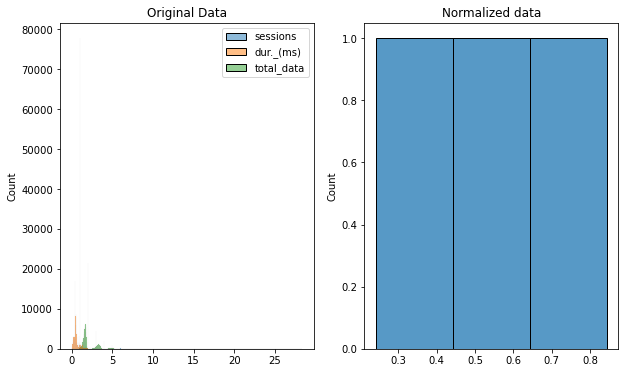

In [51]:
normalized_user_engagement = normalizer(user_engagement, ['sessions', 'dur._(ms)', 'total_data'] )

In [52]:
normalized_user_engagement.head()

,sessions,dur._(ms),total_data
0,0.481193,0.241704,0.842634
1,0.562385,0.326974,0.759481
2,0.491417,0.259674,0.831312
3,0.563167,0.196794,0.802568
4,0.488258,0.083798,0.868667


In [53]:
normalized_user_engagement.describe()

,sessions,dur._(ms),total_data
count,106855.000000,106855.000000,106855.000000
mean,0.516132,0.223813,0.822405
std,0.039218,0.067179,0.033396
min,0.428995,0.000000,0.458651
25%,0.488358,0.190006,0.807443
50%,0.508575,0.232999,0.828997
75%,0.535401,0.267627,0.845068
max,0.794010,0.511353,0.889744


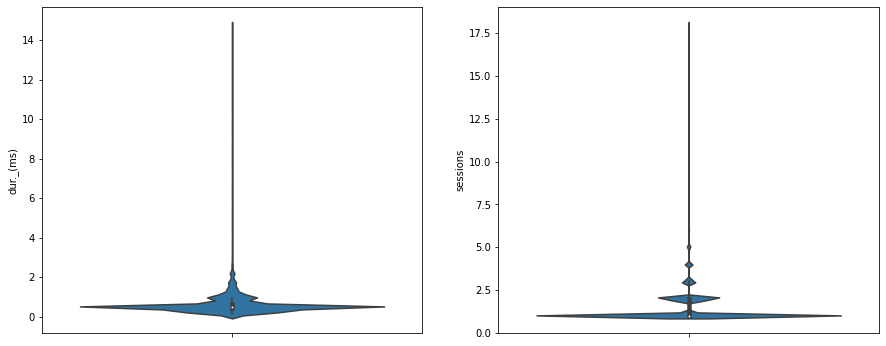

In [54]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.violinplot(y=user_engagement["dur._(ms)"])
# sns.boxplot(y=user_engagement["dur._(ms)"], color="red")
plt.subplot(1,2,2)
sns.violinplot(y=user_engagement["sessions"])
# sns.boxplot(y=user_engagement["total_data"])
plt.show()


Most of the duration,and the number of sessions lies between 1 - 2 

K-means clustering (K=3)

In [55]:
normalized__eng = normalized_user_engagement.copy()

In [56]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
label = kmeans.fit_predict(normalized__eng)
centroids = kmeans.cluster_centers_

plot the data points in the 3 clusters

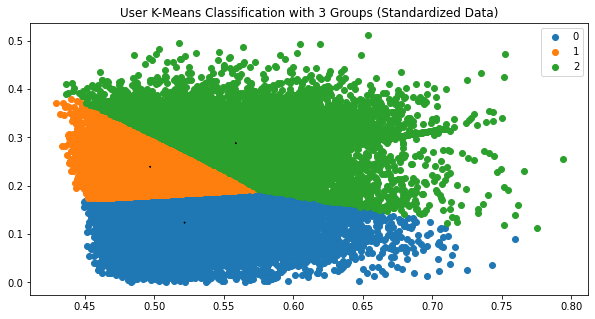

In [58]:
lables_unique = np.unique(label)
#plotting the results:
plt.figure(figsize=(10,5))
plt.title('User K-Means Classification with 3 Groups (Standardized Data)')
for i in lables_unique:
    plt.scatter(normalized__eng[label == i].iloc[:,0] , normalized__eng[label == i].iloc[:,1], marker='o', label = i)
plt.scatter(centroids[:,0] , centroids[:,1],centroids[:,2], marker='x', color = 'black')
plt.legend()
plt.show()

In [59]:
logger.info(f'# Centroids of the clustering:\n{centroids}')
logger.info(f'# The number of iterations required to converge: {kmeans.inertia_}')
logger.info(f'# The number of iterations required to converge: {kmeans.n_iter_}')

Compute the minimum, maximum, average & total non- normalized metrics for each cluster. Interpret your results visually with accompanying text explaining your findings.


In [60]:
normalized__eng.head()

,sessions,dur._(ms),total_data
0,0.481193,0.241704,0.842634
1,0.562385,0.326974,0.759481
2,0.491417,0.259674,0.831312
3,0.563167,0.196794,0.802568
4,0.488258,0.083798,0.868667


In [61]:
clustered_Df = pd.DataFrame()
clustered_Df['data_index'] = normalized__eng.index.values
clustered_Df['cluster'] = kmeans.labels_

In [62]:
clustered_Df.cluster.value_counts()

1    59339
0    24279
2    23237
Name: cluster, dtype: int64

In [63]:
u_eng = user_engagement.copy()

In [64]:
u_eng.insert(0, 'cluster', kmeans.labels_)
u_eng.head(5)

,cluster,sessions,dur._(ms),total_data
msisdn/number,,,,
3.360100e+10,1,1,0.502300,1.751134
3.360100e+10,2,1,0.581407,1.350465
3.360100e+10,1,1,0.528418,1.691663
3.360101e+10,1,1,0.349441,1.425098
3.360101e+10,0,2,0.343253,3.558224


>> Cluster 1 overview

In [65]:
cluster1 = u_eng[u_eng["cluster"]==0]
cluster1.describe()

,cluster,sessions,dur._(ms),total_data
count,24279.0,24279.000000,24279.000000,24279.000000
mean,0.0,1.270810,0.310615,2.062791
std,0.0,0.516569,0.184326,0.855597
min,0.0,1.000000,0.000000,0.848964
25%,0.0,1.000000,0.198947,1.576161
50%,0.0,1.000000,0.269995,1.716407
75%,0.0,1.000000,0.345187,1.904169
max,0.0,7.000000,2.417475,11.869787


>> Cluster 2 overview

In [67]:
cluster2 = u_eng[u_eng["cluster"] == 1]
cluster2.describe()

,cluster,sessions,dur._(ms),total_data
count,59339.0,59339.000000,59339.000000,59339.000000
mean,1.0,1.462040,0.699520,2.438037
std,0.0,0.867462,0.415454,1.401841
min,1.0,1.000000,0.336678,1.390874
25%,1.0,1.000000,0.448219,1.656089
50%,1.0,1.000000,0.530338,1.761378
75%,1.0,2.000000,0.880876,3.181156
max,1.0,11.000000,8.121661,19.062580


>> Cluster 3 overivew

In [68]:
cluster3 = u_eng[u_eng["cluster"] == 2]
cluster3.describe()

,cluster,sessions,dur._(ms),total_data
count,23237.0,23237.000000,23237.000000,23237.000000
mean,2.0,1.348023,0.707620,1.908304
std,0.0,0.870277,0.546282,1.362511
min,2.0,1.000000,0.145424,0.609523
25%,2.0,1.000000,0.462131,1.330556
50%,2.0,1.000000,0.552830,1.450059
75%,2.0,1.000000,0.694361,1.608621
max,2.0,18.000000,14.843524,28.335924


In [69]:
cluster3.sessions.count()

23237

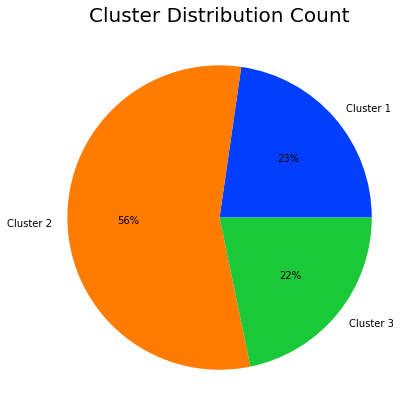

In [70]:
data = [cluster1.sessions.count(), cluster2.sessions.count(), cluster3.sessions.count()]
keys = ['Cluster 1', 'Cluster 2', 'Cluster 3']
# define Seaborn color palette to use
pl.plot_pie(data, keys, "Cluster Distribution Count")

>> Aggregate user total traffic per application and derive the top 10 most engaged users per application

In [53]:
user_app_usage = df.groupby(
    'msisdn/number').agg({ 'social_media': 'sum', 'gaming': 'sum', 'youtube': 'sum', 'netflix': 'sum', 'google': 'sum', 'email': 'sum', 'other': 'sum'})

In [54]:
user_app_usage.head()

,social_media,gaming,youtube,netflix,google,email,other
msisdn/number,,,,,,,
3.360100e+10,11.113038,1.798127,1.868944,1.918426,1.790391,1.834217,1.887333
3.360100e+10,12.009616,1.826849,1.794261,1.686560,1.816914,1.929603,1.735823
3.360100e+10,11.760653,1.921198,1.805087,1.820467,1.623812,1.953866,1.878191
3.360101e+10,11.058215,1.804159,1.696890,1.523402,1.932918,1.793159,1.675161
3.360101e+10,22.146012,3.678801,3.681928,3.744760,3.826443,3.667828,3.754265


>> Top 10 most engaged users per application

In [55]:
# Drop an outlier
user_app_usage.drop(33663706799.0, axis=0, inplace=True)

In [56]:
social_media = user_app_usage.nlargest(10, "social_media")['social_media']
gaming = user_app_usage.nlargest(10, "gaming")['gaming']
youtube = user_app_usage.nlargest(10, "youtube")['youtube']
netflix = user_app_usage.nlargest(10, "netflix")['netflix']
google = user_app_usage.nlargest(10, "google")['google']
email = user_app_usage.nlargest(10, "email")['email']
other = user_app_usage.nlargest(10, "other")['other']


In [57]:
social_media_df = pd.DataFrame()
social_media_df['User_ID'] = social_media.index
social_media_df['social_media'] = social_media.values
gaming_df = pd.DataFrame()
gaming_df['User_ID'] = gaming.index
gaming_df['gaming'] = gaming.values
youtube_df = pd.DataFrame()
youtube_df['User_ID'] = youtube.index
youtube_df['youtube'] = youtube.values

netflix_df = pd.DataFrame()
netflix_df['User_ID'] = netflix.index
netflix_df['netflix'] = netflix.values
google_df = pd.DataFrame()
google_df['User_ID'] = google.index
google_df['google'] = google.values
email_df = pd.DataFrame()
email_df['User_ID'] = email.index
email_df['email'] = email.values
others_df = pd.DataFrame()
others_df['User_ID'] = other.index
others_df['other'] = other.values

Top 10 most engaged users per application


[]

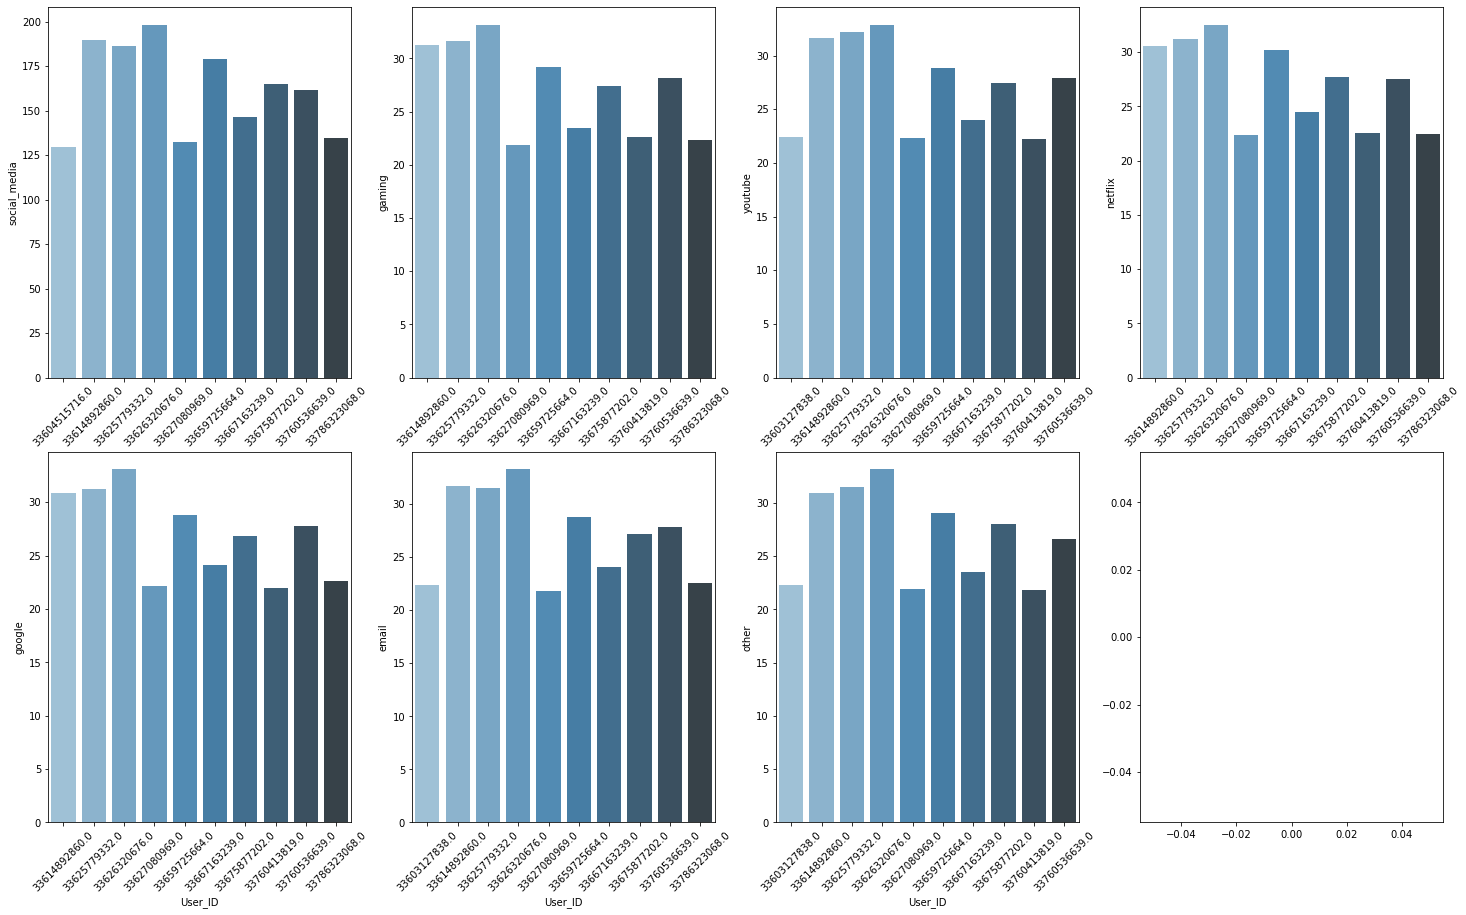

In [58]:
f, axes = plt.subplots(2, 4, figsize=(25, 15))
ax1 = sns.barplot(data=social_media_df, x='User_ID', orient='v', y='social_media', ax=axes[0,0], palette='Blues_d')
ax2 = sns.barplot(data=gaming_df, x='User_ID',orient='v', y='gaming', ax=axes[0,1], palette='Blues_d')
ax3 = sns.barplot(data=youtube_df, x='User_ID',orient='v', y='youtube', ax=axes[0,2], palette='Blues_d')
ax4 = sns.barplot(data=netflix_df, x='User_ID',orient='v', y='netflix', ax=axes[0,3], palette='Blues_d')
ax5 = sns.barplot(data=google_df, x='User_ID',orient='v', y='google', ax=axes[1,0], palette='Blues_d')
ax6 = sns.barplot(data=email_df, x='User_ID',orient='v', y='email', ax=axes[1,1], palette='Blues_d')
ax7 = sns.barplot(data=others_df, x='User_ID',orient='v', y='other', ax=axes[1,2], palette='Blues_d')
ax1.set_xticklabels(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.set_xticklabels(ax2.xaxis.get_majorticklabels(), rotation=45)
ax3.set_xticklabels(ax3.xaxis.get_majorticklabels(), rotation=45)
ax4.set_xticklabels(ax4.xaxis.get_majorticklabels(), rotation=45)
ax5.set_xticklabels(ax5.xaxis.get_majorticklabels(), rotation=45)
ax6.set_xticklabels(ax6.xaxis.get_majorticklabels(), rotation=45)
ax7.set_xticklabels(ax7.xaxis.get_majorticklabels(), rotation=45)
plt.plot()


>> Plot the top 3 most used applications using appropriate charts.  

In [59]:
top_used_applications = user_app_usage.sum()

In [60]:
top_used_applications.values

array([           -inf, 274297.09102384, 274264.33138579, 275417.11011834,
       273719.13123421, 274460.45393203, 273019.34039492])

In [61]:
top_3_used = top_used_applications.nlargest(3)

In [62]:
top_3_used

netflix    275417.110118
email      274460.453932
gaming     274297.091024
dtype: float64

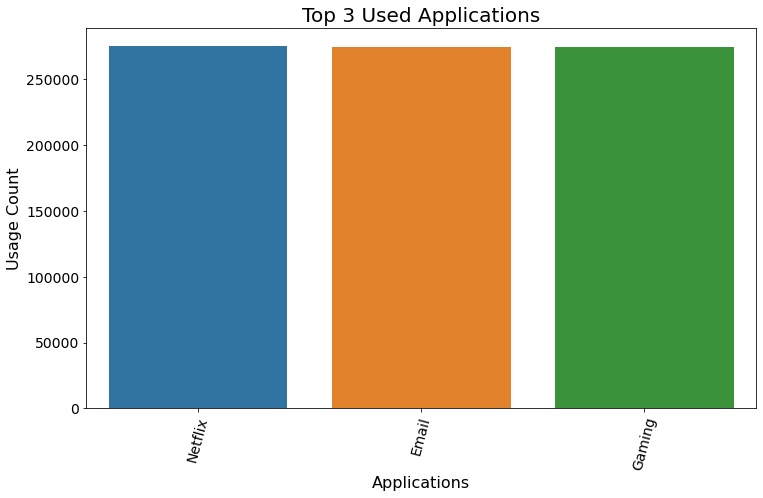

In [63]:
pl.plot_bar(top_3_used, ["Netflix", "Email", "Gaming"], top_3_used.values, "Top 3 Used Applications", "Applications", "Usage Count")

>> Using k-means clustering algorithm, group users in k engagement clusters based on the engagement metrics:

In [73]:
inertias = []
for i in range(1,16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(normalized__eng)
    inertias.append(kmeans.inertia_)

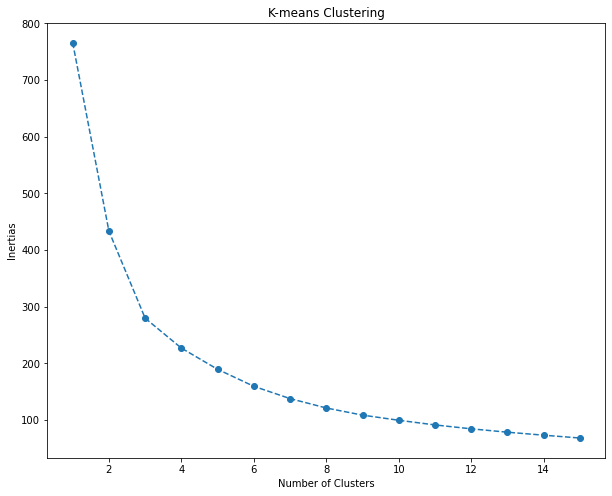

In [74]:
# Plotting the cluster size vs. inertia graph to find the optimal cluster
plt.figure(figsize = (10,8))
plt.plot(range(1, 16), inertias, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertias')
plt.title('K-means Clustering')
plt.show()

In [66]:
kl = KneeLocator(range(0, 15), inertias, curve="convex", direction="decreasing")
kl.elbow

3

In [67]:
logger.info(f"The optimal number of cluster is: {kl.elbow}")

>> Interpretation

Using the elbow method, the optimal number of cluster is 3, which is the number of cluster I used above in the k-means clustering.

Save the result

In [71]:
u_eng.shape

(106855, 4)

In [75]:
with open("../models/user_eng.pkl", "wb") as f:
    pickle.dump(kmeans, f)

In [70]:
u_eng.to_csv('../data/user_eng.csv')

In [145]:
normalized__eng.to_csv('../data/normalized_eng.csv')